In [1]:
# Importamos librerias a utilizar
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Conexion a GCP - BigQuery
import pydata_google_auth
from google.cloud import bigquery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)
client = bigquery.Client(project='gasco-analytics', credentials=credentials)

In [3]:
query_gasconnect = """
SELECT A.*,
      CASE  WHEN A.n_canales = 2 THEN 'ON-OFF'
            WHEN A.n_canales = 1 AND tipo_pedido = 'ONLINE' THEN 'ONLINE'
            WHEN A.n_canales = 1 AND tipo_pedido = 'OFFLINE' THEN 'OFFLINE'
      END AS TIPO_CLIENTE,
      B.predict_estufa,
      B.predict_parrilla,
      B.predict_cocina,
      B.predict_calefont
FROM(
      SELECT EXTRACT(YEAR FROM createdat) AS YEAR,
             CAST(TELEFONO AS INT64) AS TELEFONO,
             SUM(IND_TA) AS PEDIDOS_TA,
             SUM(KILOS_TA) AS KILOS_TA,
             COUNT(DISTINCT createdAT) AS TOTAL_PEDIDOS,
             SUM(total_kilos_pedido) AS TOTAL_KILOS,
             COUNT(DISTINCT MONTH) AS MESES_COMPRA,
             MIN(EXTRACT(DATE FROM createdAt)) AS FECHA_PRIMER_PEDIDO,
             MAX(EXTRACT(DATE FROM createdAt)) AS FECHA_ULTIMO_PEDIDO,
             AVG(dias_compra) AS frec_compra_promedio, 
             stddev(dias_compra) AS desv_frec_compra,
             COUNT(DISTINCT TIPO_PEDIDO_BIEN) AS n_canales, 
             MAX(TIPO_PEDIDO_BIEN) AS tipo_pedido 
      FROM(
            SELECT *, 
                  DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY Telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) AS dias_compra 
            FROM(
                  SELECT *,
                        EXTRACT(YEAR FROM createdAt) AS YEAR,
                        EXTRACT(MONTH FROM createdAt) as MONTH,
                        CASE WHEN mes in (5,6,7,8,9) THEN 1 ELSE 0 END AS IND_TA,
                        CASE WHEN mes in (5,6,7,8,9) THEN total_kilos_pedido ELSE 0 END AS KILOS_TA,
                        CASE WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
                              WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
                              ELSE mobile END AS Telefono,
                        CASE WHEN status = 'COMPLETED' THEN 'COMPLETADO' ELSE 'NO COMPLETADO' END AS ESTADO_PEDIDO, 
                  FROM `gasco-analytics.gasco.pedidos_gasconnect_todos_javier`
                  WHERE CAST(createdAt as DATE) >= '2019-01-01' --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
                  AND isAnulled IS NULL     --PEDIDO NO ANULADO
                  --AND mobile IS NOT NULL    --TELEFONO NO NULO
                  AND TIPO_PEDIDO_BIEN IN ('OFFLINE', 'ONLINE')
            )
            WHERE ESTADO_PEDIDO = 'COMPLETADO'
      )
      GROUP BY EXTRACT(YEAR FROM createdat), TELEFONO
) AS A   

LEFT JOIN `gasco-analytics.gasco_modelos.20210218_prediccion_modelo_uso_gas` AS B  
ON(A.TELEFONO = B.telefono)
"""

**Actualización de los datos: 2021-04-20**

In [4]:
read_data = True
if read_data:
    df_anual = pd.read_csv('datos\datos_exploratorio_fuga.csv',sep = ';', index_col = 0)
else:
    query_job = client.query(query_gasconnect)  # API request
    #rows = query_job.result()  # Waits for query to finish
    df_anual = query_job.to_dataframe()

    #guardamos como csv los datos
    df_anual.to_csv('datos\datos_exploratorio_fuga.csv',sep = ';')

df_anual.head(5)

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont
0,2019,932333069.0,0,0.0,9,510.0,1,2019-12-13,2019-12-28,1.875000,3.399054,1,ONLINE,ONLINE,1.0,0.0,1.0,1.0
1,2020,972631234.0,7,147.0,11,248.0,9,2020-02-10,2020-11-22,29.909091,12.964988,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0
2,2020,961867438.0,5,105.0,8,195.0,4,2020-08-17,2020-12-18,17.571429,13.074876,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0
3,2019,228328059.0,2,37.0,4,63.0,4,2019-03-13,2019-06-06,28.333333,7.094599,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0
4,2020,959906376.0,3,41.0,6,78.0,6,2020-01-23,2020-08-15,40.333333,26.257697,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0


In [5]:
df_anual['FECHA_PRIMER_PEDIDO'] = pd.to_datetime(df_anual['FECHA_PRIMER_PEDIDO'])
df_anual['FECHA_ULTIMO_PEDIDO'] = pd.to_datetime(df_anual['FECHA_ULTIMO_PEDIDO'])

df_anual['porcentaje_pedidos_TA'] = df_anual['PEDIDOS_TA']/df_anual['TOTAL_PEDIDOS']
df_anual['recencia'] = (date(2021, 4, 7) - df_anual['FECHA_ULTIMO_PEDIDO'].dt.date).dt.days

df_anual.head(2)

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia
0,2019,932333069.0,0,0.0,9,510.0,1,2019-12-13,2019-12-28,1.875000,3.399054,1,ONLINE,ONLINE,1.0,0.0,1.0,1.0,0.000000,466
1,2020,972631234.0,7,147.0,11,248.0,9,2020-02-10,2020-11-22,29.909091,12.964988,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0,0.636364,136


In [6]:
df_2019 = df_anual[df_anual.YEAR == 2019]
df_2020 = df_anual[df_anual.YEAR == 2020]
df_2021 = df_anual[df_anual.YEAR == 2021]

clientes_TA_2020 = df_2020[df_2020.porcentaje_pedidos_TA == 1]
clientes_TA_2019 = df_2019[df_2019.porcentaje_pedidos_TA == 1]

print('clientes que compran en TA en 2020:',len(clientes_TA_2020))
print('clientes que compran en TA en 2019:',len(clientes_TA_2019))

clientes_TA_total = clientes_TA_2020.merge(clientes_TA_2019,
                                           how = 'outer',
                                           on = 'TELEFONO',
                                           suffixes=('_2020', '_2019'),
                                           indicator = True)
clientes_TA_total.to_csv('clientes_TA_2019_2020.csv',sep = ';')

clientes que compran en TA en 2020: 65158
clientes que compran en TA en 2019: 31365


In [7]:
query_demanda = """
SELECT YEAR, 
       MONTH, 
       COUNT(DISTINCT TELEFONO) AS CLIENTES

FROM(
    SELECT *, 
            DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY Telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) AS dias_compra 
    FROM(
            SELECT *,
                EXTRACT(YEAR FROM createdAt) AS YEAR,
                EXTRACT(MONTH FROM createdAt) as MONTH,
                CASE WHEN mes in (5,6,7,8,9) THEN 1 ELSE 0 END AS IND_TA,
                CASE WHEN mes in (5,6,7,8,9) THEN total_kilos_pedido ELSE 0 END AS KILOS_TA,
                CASE WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
                        WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
                        ELSE mobile END AS Telefono,
                CASE WHEN status = 'COMPLETED' THEN 'COMPLETADO' ELSE 'NO COMPLETADO' END AS ESTADO_PEDIDO, 
            FROM `gasco-analytics.gasco.pedidos_gasconnect_todos_javier`
            WHERE CAST(createdAt as DATE) >= '2019-01-01' --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
            AND isAnulled IS NULL     --PEDIDO NO ANULADO
            --AND mobile IS NOT NULL    --TELEFONO NO NULO
            AND TIPO_PEDIDO_BIEN IN ('OFFLINE', 'ONLINE')
    )
    WHERE ESTADO_PEDIDO = 'COMPLETADO'
) 
GROUP BY YEAR, MONTH
"""

query_job = client.query(query_demanda)  # API request
#rows = query_job.result()  # Waits for query to finish
df_demanda_mensual = query_job.to_dataframe()
df_demanda_mensual.to_csv('demanda_mensual.csv',sep = ';')

In [8]:
df_demanda_mensual.head()

,YEAR,MONTH,CLIENTES
0,2019,7,75795
1,2019,6,60080
2,2019,8,66591
3,2019,5,47773
4,2019,3,28559


In [9]:
df_demanda_mensual['FECHA'] = pd.to_datetime(df_demanda_mensual.YEAR*10000+df_demanda_mensual.MONTH*100+1,format='%Y%m%d')
df_demanda_mensual.head(2)

,YEAR,MONTH,CLIENTES,FECHA
0,2019,7,75795,2019-07-01
1,2019,6,60080,2019-06-01


<AxesSubplot:xlabel='MONTH', ylabel='CLIENTES'>

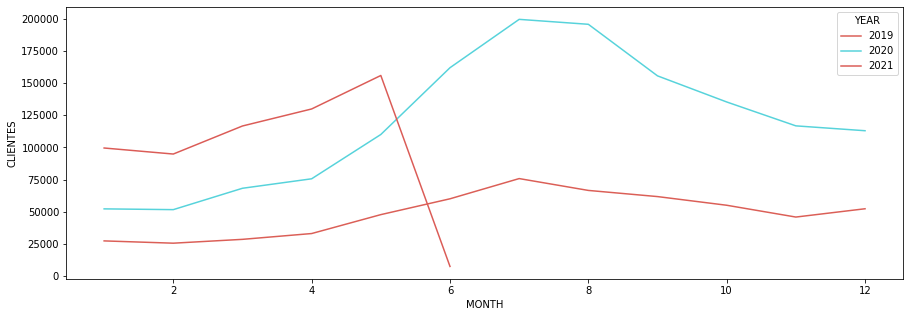

In [10]:
#years = df_demanda_mensual.YEAR.unique()

#fig, axs = plt.subplots(len(years), figsize = (15,5), sharex = True, sharey = True)
#fig.suptitle('Clientes Mensuales', fontsize=16)

#for i in range(len(years)):
#    df = df_demanda_mensual[df_demanda_mensual.YEAR == years[i]]
#    sns.lineplot(ax = axs[i], data = df, x = 'MONTH', y = 'CLIENTES')

f, ax = plt.subplots(figsize = (15,5))
#sns.set(style="whitegrid")
sns.lineplot(data = df_demanda_mensual,
             x = 'MONTH', y = 'CLIENTES', hue = 'YEAR',palette = 'hls')

#### Juntar estos dos graficos en uno

<AxesSubplot:xlabel='FECHA', ylabel='CLIENTES'>

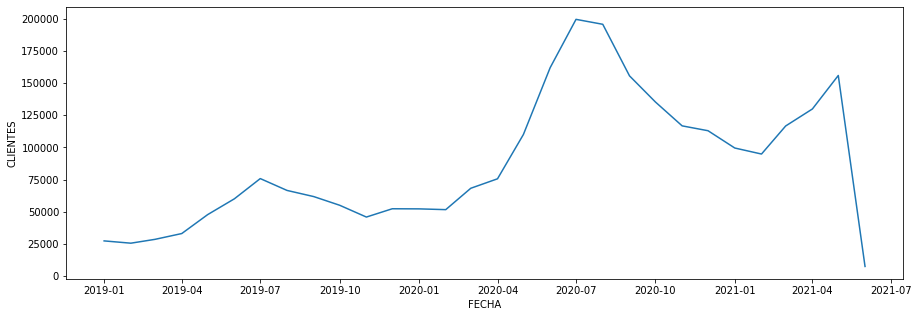

In [11]:
f, ax = plt.subplots(figsize = (15,5))
sns.lineplot(data = df_demanda_mensual,
             x = 'FECHA', y = 'CLIENTES')

### Etiquetas de los clientes por año y comparacion con recencia

In [12]:
today = date.today()
print(today)

2021-06-02


In [13]:
df_2021

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia
26,2021,990680902.0,0,0.0,4,78.0,4,2021-01-16,2021-04-12,35.750000,15.085865,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0,0.0,-5
27,2021,976650378.0,0,0.0,2,71.0,2,2021-01-25,2021-03-24,101.500000,61.518290,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0,0.0,14
54,2021,995674637.0,0,0.0,5,202.0,2,2021-02-21,2021-03-06,3.250000,3.774917,1,ONLINE,ONLINE,NaN,NaN,NaN,NaN,0.0,32
66,2021,940257356.0,0,0.0,3,71.0,1,2021-01-17,2021-01-29,18.666667,21.962089,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0,0.0,68
70,2021,943541581.0,0,0.0,3,66.0,3,2021-01-05,2021-04-05,34.000000,33.045423,1,ONLINE,ONLINE,0.0,0.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347038,2021,995187887.0,0,0.0,1,11.0,1,2021-03-26,2021-03-26,220.000000,NaN,1,ONLINE,ONLINE,0.0,0.0,1.0,0.0,0.0,12
347059,2021,979775821.0,0,0.0,1,11.0,1,2021-01-06,2021-01-06,NaN,NaN,1,OFFLINE,OFFLINE,0.0,0.0,0.0,0.0,0.0,91
347065,2021,972996029.0,0,0.0,1,11.0,1,2021-03-13,2021-03-13,79.000000,NaN,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0,0.0,25
347069,2021,976458847.0,0,0.0,1,11.0,1,2021-04-01,2021-04-01,NaN,NaN,1,OFFLINE,OFFLINE,NaN,NaN,NaN,NaN,0.0,6


#### Dataframe labels Fuga

In [14]:
df_fuga = pd.read_csv('cortes_frecuencia.csv', sep = ';', index_col = 0)

In [15]:
choices_NB = ['inacto','activo bajo','activo alto']

conditions_NB = [
       (df_fuga['MESES_COMPRA'] <= 3), 
       ((df_fuga['MESES_COMPRA'] > 3) & (df_fuga['MESES_COMPRA'] <= 7)),
       (df_fuga['MESES_COMPRA'] > 7)]

df_fuga['estados_no_binarios'] = np.select(conditions_NB, choices_NB, default=np.nan)

df_fuga.head(2)

,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,...,"('TOTAL_KILOS', 'Q1')","('TOTAL_KILOS', 'Q2')","('TOTAL_KILOS', 'Q3')","('TOTAL_KILOS', 'Q90')","('TOTAL_KILOS', 'max')",fecha_primera_compra,meses_permanencia,tasa_meses,estados_binarios,estados_no_binarios
0,222183113.0,10,154,11,165,5,2020-06-10,2020-10-01,11.3,5.355164,...,77,105,150.0,215.0,5710,2020-06-10,11,0.454545,inacto,activo bajo
1,323617342.0,4,40,5,55,5,2020-05-26,2020-10-21,37.0,31.251667,...,77,105,150.0,215.0,5710,2020-05-26,12,0.416667,inacto,activo bajo


In [16]:
print(len(df_fuga))
print(df_fuga.TELEFONO.nunique())

579026
579025


In [ ]:
df_fuga[['estados_no_binarios','TELEFONO']].groupby('estados_no_binarios').count().reset_index()

In [ ]:
df_inactivos = df_fuga[df_fuga.estados_no_binarios == 'inacto']
df_clientes_nuevos = df_inactivos[df_inactivos['fecha_primera_compra'] >= '2021-04-01']
print(len(df_clientes_nuevos))

df_clientes_nuevos.MESES_COMPRA.unique()

In [ ]:
df_AA = df_fuga[df_fuga.estados_no_binarios == 'activo alto']
df_AA_abril = df_AA[df_AA['FECHA_ULTIMO_PEDIDO'] >= '2021-04-01'] 
print(len(df_AA),len(df_AA_abril))


df_AB = df_fuga[df_fuga.estados_no_binarios == 'activo bajo']
df_AB_abril = df_AB[df_AB['FECHA_ULTIMO_PEDIDO'] >= '2021-04-01'] 
print(len(df_AB),len(df_AB_abril))

In [ ]:
clientes_TA = pd.read_csv('clientes_TA_2019_2020.csv',sep = ';', index_col = 0)
clientes_TA['FECHA_PRIMER_PEDIDO_2020']= pd.to_datetime(clientes_TA['FECHA_PRIMER_PEDIDO_2020'])

print(len(clientes_TA))

clientes_TA.head(2)

In [ ]:
clientes_TA_mayo_2020 = clientes_TA[(clientes_TA.FECHA_PRIMER_PEDIDO_2020 >= '2020-05-01') &
                                    (clientes_TA.FECHA_PRIMER_PEDIDO_2020 <= '2020-05-31')]
print(clientes_TA_mayo_2020.TELEFONO.nunique())

In [ ]:
#clientes_TA_mayo_2020.FECHA_PRIMER_PEDIDO_2020.max()